<a href="https://colab.research.google.com/github/MustafaAbbasi98/Spark-MLLib-Twitter-Sentiment-Analysis/blob/main/PySpark_MLLib_Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis on 1.6 million tweets with PySpark and MLLib

In [1]:
!pip install pyspark spark-nlp findspark
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.2/579.2 kB 34.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=f31b4c97a79e8d9df9e7ab3dc19538a9c6af580b032b587e562ecf5c640cd3f5
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


## Spark Setup

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
#MUST RUN THIS BEFORE LAUNCHING SPARK SESSION
import findspark
findspark.init()

In [4]:
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [5]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = SparkContext(conf=conf)
# spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

Check if spark session is running properly

In [6]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

## Kaggle Setup

In [7]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mustafaabbasi","key":"d5ee714a9d75a69a50d8ed5b0ef5a73a"}'}

In [8]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [9]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

Now, let's download the `sentiment140` dataset containing 1.6 million tweets labelled for positive or negative sentiments

In [11]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 84% 68.0M/80.9M [00:00<00:00, 118MB/s] 
100% 80.9M/80.9M [00:00<00:00, 87.7MB/s]


In [12]:
!unzip /content/sentiment140.zip -d /content/tweets/

Archive:  /content/sentiment140.zip
  inflating: /content/tweets/training.1600000.processed.noemoticon.csv  


## Testing Spark

In [24]:
sdf = spark.read.csv("/content/tweets/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1",
                     inferSchema=True, header=False)

In [25]:
sdf.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



Let's convert the pyspark dataframe to pandas-on-spark dataframe (spark's own pandas api) for more intuitive data manipulation.

## Data Preprocessing with Spark & Pandas


In [26]:
df = pd.read_csv("/content/tweets/training.1600000.processed.noemoticon.csv",  encoding = "ISO-8859-1", engine="python")

In [27]:
df.columns = ["label", "time", "date", "query", "username", "text"]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [29]:
df.isna().sum()

,0
label,0
time,0
date,0
query,0
username,0
text,0


In [30]:
df['date'] = pd.to_datetime(df['date'])

<ipython-input-30-e8d2d516eb0e>:1: FutureWarning: Parsed string "Mon Apr 06 22:19:49 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'])


In [31]:
df['date'].head()

,date
0,2009-04-06 22:19:49
1,2009-04-06 22:19:53
2,2009-04-06 22:19:57
3,2009-04-06 22:19:57
4,2009-04-06 22:20:00


In [32]:
df.label.value_counts()

,count
label,
4,800000
0,799999


In [33]:
df['query'].value_counts()

,count
query,
NO_QUERY,1599999


### Converting back-and-forth from Pandas and processing in Spark

In [34]:
psdf = ps.from_pandas(df)
psdf.head()

,label,time,date,query,username,text
0,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,2009-04-06 22:20:00,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [35]:
type(psdf)

pyspark.pandas.frame.DataFrame

In [36]:
psdf.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [37]:
psdf.rename(columns={'label': 'sentiment'}, inplace=True)

In [38]:
psdf.loc[psdf['sentiment']==4, 'sentiment'] = 1 #positive sentiment

In [39]:
# psdf['sentiment'].value_counts()

In [40]:
import re
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, IntegerType

In [85]:
# Credits to  https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-using-word2vec-bilstm
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_tweet(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    tweet = tweet.strip()
    return tweet

In [42]:
psdf['cleaned_text'] = psdf['text'].apply(preprocess_tweet)

In [43]:
# psdf['cleaned_text'].head()

In [45]:
sdf = psdf.to_spark()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [46]:
type(sdf)

pyspark.sql.dataframe.DataFrame

We can use `sdf.explain()` to see the query plan internally generated by spark. Remember that spark executes dataframe transformations *lazily* and only actually executes them once an action has been taken (like calling `sdf.count()` or `sdf.show()`).

In [47]:
sdf.explain()

== Physical Plan ==
*(2) Project [CASE WHEN (label#554L = 4) THEN 1 ELSE label#554L END AS sentiment#641L, time#555L, date#556, query#557, username#558, text#559, pythonUDF0#676 AS cleaned_text#668]
+- ArrowEvalPython [pudf(__index_level_0__#553L, text#559)#665], [pythonUDF0#676], 200
   +- *(1) Scan ExistingRDD[__index_level_0__#553L,label#554L,time#555L,date#556,query#557,username#558,text#559]




**As we can see above, Spark lazy executes it's optimized query plan. If we use this dataframe further for ML, it will take a long time since Spark will carry out the entire plan once model training starts. Therefore, the best approach is to save the preprocessed dataframe to storage and then read it back before training models on it.**

In [48]:
sdf.write.csv("/content/preprocessed_data.csv", header=True, mode='overwrite') #Will take some time

In [49]:
sdf = spark.read.csv("/content/preprocessed_data.csv", header=True, inferSchema=True)

## Predicting Sentiment with Spark MLLib
- Using TF-IDF features

In [50]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, HashingTF, IDF

In [51]:
tokenizer = Tokenizer(inputCol='cleaned_text', outputCol='words')
countTokens = udf(lambda words: len(words), IntegerType())

tokenized = tokenizer.transform(sdf)
tokenized.show()

+---------+----------+-------------------+--------+---------------+--------------------+--------------------+--------------------+
|sentiment|      time|               date|   query|       username|                text|        cleaned_text|               words|
+---------+----------+-------------------+--------+---------------+--------------------+--------------------+--------------------+
|        0|1467810672|2009-04-06 22:19:49|NO_QUERY|  scotthamilton|is upset that he ...|is upset that he ...|[is, upset, that,...|
|        0|1467810917|2009-04-06 22:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|<user> i dived ma...|[<user>, i, dived...|
|        0|1467811184|2009-04-06 22:19:57|NO_QUERY|        ElleCTF|my whole body fee...|my whole body fee...|[my, whole, body,...|
|        0|1467811193|2009-04-06 22:19:57|NO_QUERY|         Karoli|@nationwideclass ...|<user> no  it s n...|[<user>, no, , it...|
|        0|1467811372|2009-04-06 22:20:00|NO_QUERY|       joy_wolf|@Kwesidei not th

In [52]:
tokenized.select('cleaned_text', 'words').show(5)

+--------------------+--------------------+
|        cleaned_text|               words|
+--------------------+--------------------+
|is upset that he ...|[is, upset, that,...|
|<user> i dived ma...|[<user>, i, dived...|
|my whole body fee...|[my, whole, body,...|
|<user> no  it s n...|[<user>, no, , it...|
|<user> not the wh...|[<user>, not, the...|
+--------------------+--------------------+
only showing top 5 rows



In [53]:
# hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
# featurizedData = hashingTF.transform(tokenized)

In [54]:
# idf = IDF(inputCol="rawFeatures", outputCol="features")
# idfModel = idf.fit(featurizedData)
# rescaledData = idfModel.transform(featurizedData)
# rescaledData.select("sentiment", "features").show(5)

In [55]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [56]:
tokenizer = Tokenizer(inputCol='cleaned_text', outputCol='words')
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

In [57]:
# sdf_ml = sdf.sample(fraction=0.2, seed=42)

Let's split the data into training and test sets (10% for testing i.e 160k tweets held out for testing)


In [58]:
(train_sdf, test_sdf) = sdf.randomSplit([0.9, 0.1])

In [59]:
train_sdf.explain()

== Physical Plan ==
*(1) Sample 0.0, 0.9, false, 783719150883625966
+- *(1) Sort [sentiment#702 ASC NULLS FIRST, time#703L ASC NULLS FIRST, date#704 ASC NULLS FIRST, query#705 ASC NULLS FIRST, username#706 ASC NULLS FIRST, text#707 ASC NULLS FIRST, cleaned_text#708 ASC NULLS FIRST], false, 0
   +- FileScan csv [sentiment#702,time#703L,date#704,query#705,username#706,text#707,cleaned_text#708] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/preprocessed_data.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<sentiment:int,time:bigint,date:timestamp,query:string,username:string,text:string,cleaned_...




Now, let's define our `RandomForestClassifier`. Note that i have set `labelCol=sentiment` to override the default.

In [60]:
rf = RandomForestClassifier(labelCol="sentiment",
                            featuresCol="features",
                            numTrees=5)

Now that we have our model and transformers, let's create a Spark Pipeline with our transformers (tokenizer, hashingTF, idf) and our estimator (random forest)

In [61]:
pipeline = Pipeline(stages=[tokenizer,
                            hashingTF,
                            idf,
                            rf])

Let's train our model on the training subset

In [62]:
model = pipeline.fit(train_sdf)

Now, let's obtain predictions on the test set

In [63]:
# Make predictions.
predictions = model.transform(test_sdf)

# Select example rows to display.
predictions.select("prediction", "sentiment", "features").show(5)

+----------+---------+--------------------+
|prediction|sentiment|            features|
+----------+---------+--------------------+
|       0.0|        0|(1000,[17,185,188...|
|       0.0|        0|(1000,[89,262,307...|
|       1.0|        0|(1000,[108,294,48...|
|       0.0|        0|(1000,[17,66,253,...|
|       1.0|        0|(1000,[17,22,60,3...|
+----------+---------+--------------------+
only showing top 5 rows



## Model Evaluation
- Using built-in binary and multiclass evaluators
- Binary evaluator only allows area under ROC or PR curve as metric
- Multiple options for multiclass evaluator metric

In [64]:
evaluator=BinaryClassificationEvaluator(labelCol='sentiment') #metric is areaUnderROC by default

In [65]:
evaluator.evaluate(predictions)

0.6737682628747435

In [66]:
evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderPR'})

0.6640222679149226

In [67]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='sentiment',
    metricName='accuracy'
)

In [68]:
evaluator.evaluate(predictions)

0.6276336937691918

In [69]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='sentiment',
    metricName='f1'
)

In [70]:
evaluator.evaluate(predictions)

0.6259009135262323

In [71]:
pred_df = predictions.select("prediction", "sentiment", "text", "cleaned_text").toPandas()
pred_df.head()

,prediction,sentiment,text,cleaned_text
0,0.0,0,@Kenichan I dived many times for the ball. Man...,<user> i dived many times for the ball manage...
1,0.0,0,I just re-pierced my ears,i just re pierced my ears
2,1.0,0,about to file taxes,about to file taxes
3,0.0,0,He's the reason for the teardrops on my guitar...,he s the reason for the teardrops on my guitar...
4,1.0,0,just leaving the parking lot of work!,just leaving the parking lot of work


We can create a confusion matrix as well

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [83]:
from sklearn.metrics import classification_report
print(classification_report(pred_df.sentiment.values, pred_df.prediction.values))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60     80120
           1       0.61      0.70      0.65     79779

    accuracy                           0.63    159899
   macro avg       0.63      0.63      0.63    159899
weighted avg       0.63      0.63      0.63    159899



In [79]:
cm = confusion_matrix(pred_df.sentiment.values, pred_df.prediction.values)

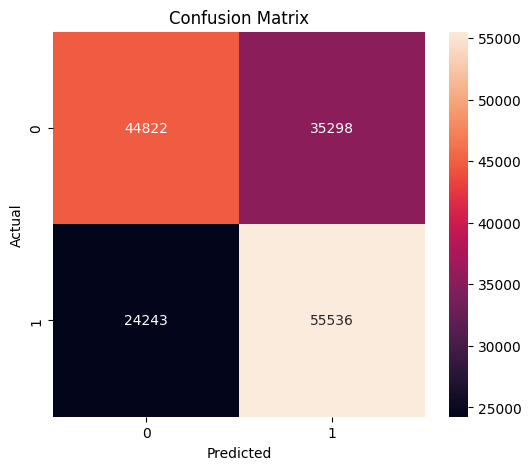

In [80]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning in Spark MLLib
- Using built-in ParamGridBuilder and CrossValidator

In [ ]:
#Explore other parameter combinations as desired
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [128, 512]) \
    .addGrid(rf.minInfoGain, [0.0, 0.1]) \
    .build()

Let's define our `CrossValidator` with the given pipeline, paramGrid and evaluator.

*Caution: This will take time depending on your cluster*

In [ ]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='sentiment'), #optimizing area under roc as default
                          numFolds=3, #increase as needed
                          )

In [ ]:
cv_model = crossval.fit(train_sdf)

We can observe the metrics for all of our parameter combinations using the `cv_model.avgMetrics` attribute.

In [ ]:
cv_model.avgMetrics

[0.6546755803575374, 0.5, 0.6679201077915694, 0.5]

In [ ]:
cv_model.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_ee5d6d0c7d9c', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_ee5d6d0c7d9c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_ee5d6d0c7d9c', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_ee5d6d0c7d9c', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

Let's now evaluate the best model found via cross validation on our test set. Note that `cv_model.transform` will train the ***best*** model it found during cross-validation on the target set

In [ ]:
predictions = cv_model.transform(test_sdf)

In [ ]:
evaluator=BinaryClassificationEvaluator(labelCol='sentiment')
evaluator.evaluate(predictions)

0.6880156471184291

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='sentiment', metricName='f1')
evaluator.evaluate(predictions)

0.6268249652768831

## Additional Steps:

Here are some additional steps you can take to improve this model further:

*   Try a different model in MLLib like XGBoost
*   Try different set of features like n-grams
*   Explore other combinations of hyperparameters
*   Explore additional preprocessing techniques (special tokens for capital letters, exclamations, etc.)
*   Use error-analysis to figure out how to improve model



